In [1]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1242


In [2]:
using JuliaDB
using Flux
using Statistics
using CuArrays
using CUDAnative

# allowscalar(false)

┌ Info: Precompiling JuliaDB [a93385a2-3734-596a-9a66-3cfbb77141e6]
└ @ Base loading.jl:1242
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1242


In [3]:
include("../Wave/Wave.jl")
using Main.Wave

# Data

In general, this model is meant to work on 1D timeseries data. Let's prepare some "sin" waves of data that alternate between -1 and 1.

We have a `global parameter` which is the class of the sin wave. We have three different sin waves and this parameter allows us to train the model and distinguish between them. Global parameters stay the same over time series. The equivalent in FX data might be a variable describing what currency pair we're training on.

We also have a `local parameter` which is the time. I've included it because I want the model to figure out that whenever `t = 500` the "sign" is instantly flipped. Understandably, local parameters change continuously with the data. The equivalent in FX data might be a variable describing the spread at each timestep.

In [4]:
# Create 1 million points of data

t = collect(1f0:1000000f0)
x1  = [iseven(n÷500) ? n : -n for n in t] # flip the sign every 500 steps

# put the data in a JuliaDB table for easy preparation
tbl = table((t     = t,
             sin   = tanh.(sin.(x1./100).*1),  # this is the data we want it to learn
             sin2  = tanh.(sin.(x1./100).*2),  # this is similar data, but a 2nd class
             sin4  = tanh.(sin.(x1./100).*4),  # this is similar data, but a 3rd class
             lc1   = [sin((i%500)*2π/500) for i in abs.(x1)],  # encode time using sin
             lc2   = [cos((i%500)*2π/500) for i in abs.(x1)]), # encode time using cos
             pkey  = [:t]
             );

In [5]:
tblline = JuliaDB.select(tbl,:sin);

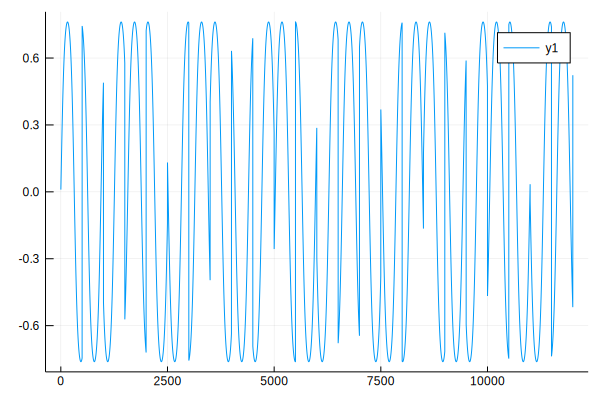

In [6]:
plot(tblline[1:12000])

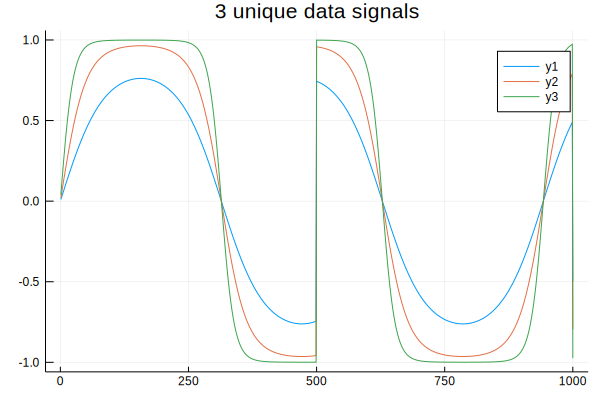

In [7]:
plot(vcat([[i.sin i.sin2 i.sin4] for i in rows(tbl)[1:1000]]...), title = "3 unique data signals")

# Network

References:

[Original WaveNet Paper](https://arxiv.org/pdf/1609.03499.pdf)

[Baidu Improved WaveNet](https://arxiv.org/pdf/1702.07825.pdf)


The main component of a Wave `Net` object is a convolution layer `WConv` with a kernel of `(2,)` a stride of `(1,)` a dilation size of `(2^layer)` and pad of `(2^layer)`. The dilation inserts 0s between each kernel stride, so for each layer you get more and more 0s between weights. The pad pushes everything to the side by an equal amount and so you get this nice log2 tree-like pattern. Naturally, more layers mean a bigger receptive field. By default the maximum dilation size goes to 512 and then starts at 2 again.

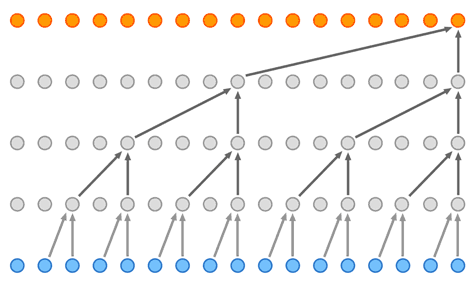

This architecture can be used in many ways but consider a scenario where you wish to predict the next sample given an arbitrary dataset.

The data first needs to be normalized between `-1 < x < 1` and then companded using [μlaw encoding](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm) so the input values are quantized to 256 values between `-128f0 < x < 127f0`. The data needs to be shaped like `(w x 1 x channels x batchsize)`.

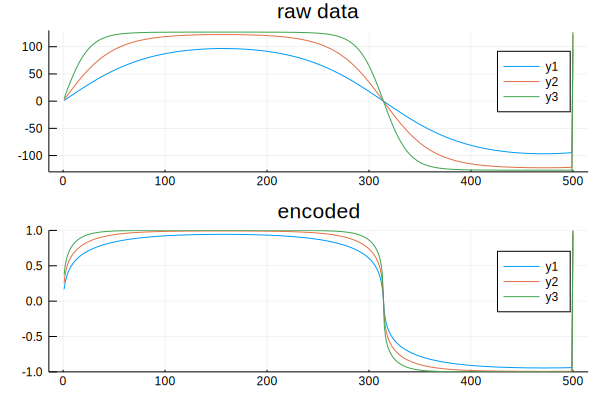

In [8]:
testμ = vcat([[i.sin i.sin2 i.sin4] for i in rows(tbl)[1:500]]...)
p1 = plot(testμ .* 127,        ylims=(-130,130), title = "raw data")
p2 = plot(Wave.μlawcmp(testμ), ylims=(-1,1), title = "encoded")
plot(p1, p2, layout=(2, 1))

Imagine the following being provided to a Wave `Net` object.
data: 1024 x 1 x 1 x 1 array
cond: 5 x 1 array

This is what the object will do:
- Run through a 1x1 Conv layer increasing the channels from `1 => 64` and adding a "causal" pad of `(1,)`.
- Run through several `WConv` layers with increasing dilation levels.
  - The layer begins by passing input `x` through a 2x1 "dilated Conv" doubling the channels to 128.
  - The data is passed on to a "gated activation unit" which splits the channels into two halves.
    - The "conditioning" data is added to each half.
    - The first half goes to a `tanh` and the second half to a `σ`. 
    - Both outputs are then elementwise multiplied and passed forward as `dat` with 64 channels.
  - The `dat` goes to a 1x1 "skip Conv" whose `64 => 256` channel output `WConv.skp` is saved for later.
  - The `dat` goes to a 1x1 "residual Conv", the input is added, and the result is passed to the next `WConv`.
- A reduce operation grabs the `WConv.skp` from every layer and adds them together.
- The data is passed through two `relu` and two 1x1 Conv units
- A softmax is applied to the 256 channels of the last sample and outputs a probability distribution

The network is fully auto-regressive and can be trained using crossentropy.

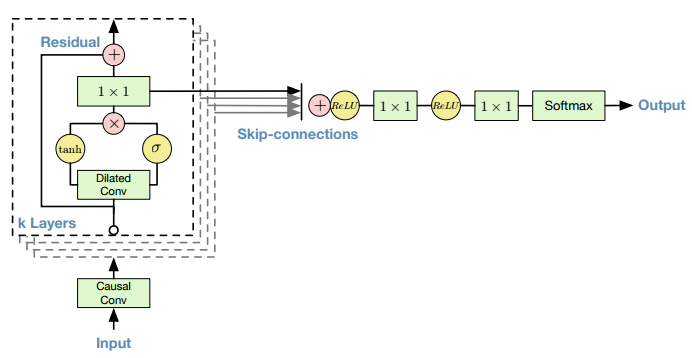

# WAVENET

In [9]:
net = Wave.Net(10, cond=5)

:: Wave.Net ::
Hidden layers:     10
Receptive field:   1024
Residual channels: 64
Skip channels:     256
Conditioning vars: 5
GPU enabled:       yes

The format of the data created by `Wave.preptbl` below is:
```
[                            <== an array:    dat
    [                        <== a batch:     dat[1]
        [                    <== the data:    dat[1][1]
            x1,              <== timeseries:  dat[1][1][1] 
            x2               <== condvars:    dat[1][1][2]
        ]          
        [
            y                <== labels:      dat[1][2]
        ]                  
    ]
    ...
]```

In [10]:
dat = Wave.preptbl(tbl, dt=:sin, 
                        lc=(:lc1, :lc2), 
                        gc=(:sin, :sin2, :sin4), 
                        samples=1024, 
                        batchsize=8, 
                        stride=128)

dat_t = gpu.(dat[1:end-1])
dat_v = gpu(dat[end]);

Data points in input: 1000000
Augmenting data in strides of 128


Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


Merging, sorting, and filtering...
Data points after augmentation: 7983105
Grouping into batches of 8


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Size of dataset: 8 MB
Training samples: 7792


In [11]:
opt = ADAM(0.001)
loss(x, y) = Flux.crossentropy(net(x), y)
function accuracy()
    println("Mean Average Error:  ", 
        mean(abs.(Flux.onecold(net(dat_v[1]), -128:127) - 
             Flux.onecold(dat_v[2], -128:127))),
        " out of 128")
    println("Cross Entropy:       ", loss(dat_v[1], dat_v[2]).data)
end

accuracy (generic function with 1 method)

In [12]:
Flux.@epochs 4 Flux.train!(loss, params(net), dat_t, opt, cb = Flux.throttle(accuracy, 60))

┌ Info: Epoch 1
└ @ Main /home/paragon/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105
┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /home/paragon/.julia/packages/GPUArrays/fLiQ1/src/indexing.jl:16


Mean Average Error:  75.75 out of 128
Cross Entropy:       5.666766
Mean Average Error:  2.5 out of 128
Cross Entropy:       2.760278
Mean Average Error:  2.625 out of 128
Cross Entropy:       2.0097108


┌ Info: Epoch 2
└ @ Main /home/paragon/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


Mean Average Error:  1.75 out of 128
Cross Entropy:       1.3821087
Mean Average Error:  1.0 out of 128
Cross Entropy:       1.5182582
Mean Average Error:  0.75 out of 128
Cross Entropy:       1.5393806


┌ Info: Epoch 3
└ @ Main /home/paragon/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


Mean Average Error:  1.0 out of 128
Cross Entropy:       1.0711076
Mean Average Error:  0.875 out of 128
Cross Entropy:       1.3398004
Mean Average Error:  0.75 out of 128
Cross Entropy:       1.5376196


┌ Info: Epoch 4
└ @ Main /home/paragon/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


Mean Average Error:  0.875 out of 128
Cross Entropy:       0.8963004


InterruptException: InterruptException:

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


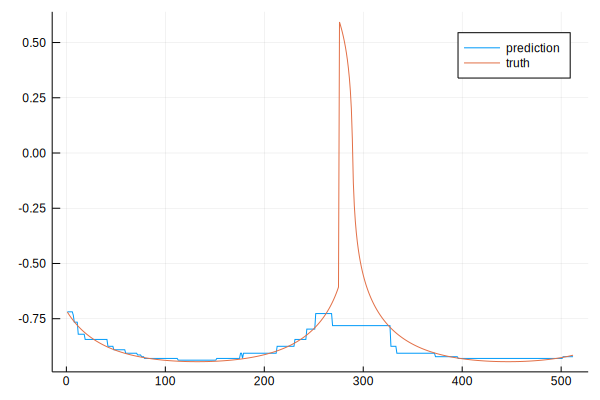

In [16]:
testpred, testlbl = Wave.testmodel(net, filter(x -> 1200 < x.t, tbl), 
    dt=:sin, 
    lc=(:lc1, :lc2), 
    gc=(:sin, :sin2, :sin4))

plot(hcat(testpred, testlbl), label=["prediction", "truth"])